# Homework 6

In [ ]:
import pandas as pd
import numpy as np
from sympy import Symbol, lambdify
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv('Input/training.dat', sep=' ', header=None, names=['x', 'y']);
test_data = pd.read_csv('Input/test.dat', sep=' ', header=None, names=['x', 'y']);

#x_train = np.array(train_data['x'])
#y_train = np.array(train_data['y'])

norm_train = np.array(train_data)
norm_train = (norm_train - norm_train.mean(0)) / norm_train.std(0)

x_train = norm_train[:,0]
y_train = norm_train[:,1]

w0 = Symbol("w0")
w1 = Symbol("w1")
w2 = Symbol("w2")

func_a_coefficients = np.array([np.sum(y_train**2), 1*np.size(y_train), np.sum((x_train**2)), np.sum(2*y_train), np.sum(2*y_train*x_train), np.sum(2*x_train)])
func_a_variables = np.array([1, w0**2, w1**2, -w0, -w1, w0*w1])

func_b_coefficient = np.array([np.sum(y_train**2), 1*np.size(y_train), np.sum(x_train**2), np.sum(x_train**4), np.sum(2*y_train), np.sum(2*y_train*x_train), np.sum(2*y_train*x_train**2), np.sum(2*x_train), np.sum(2*x_train**2), np.sum(2*x_train**3)])
func_b_variables = np.array([1, w0**2, w1**2, w2**2, -w0, -w1, -w2, w0*w1, w0*w2, w1*w2])

func_a = np.sum(func_a_coefficients*func_a_variables)
f_a = lambdify([[w0, w1]], func_a, "numpy")
gf_a = lambdify([[w0, w1]], func_a.diff([[w0, w1]]), "numpy")
grad_fa = lambda x_arr : np.array(gf_a(x_arr), 'float64').reshape(1,len(x_arr))

func_b = np.sum(func_b_coefficient*func_b_variables)
f_b = lambdify([[w0, w1, w2]], func_b, "numpy")
gf_b = lambdify([[w0, w1, w2]], func_b.diff([[w0, w1, w2]]), "numpy")
grad_fb = lambda x_arr : np.array(gf_b(x_arr), 'float64').reshape(1,len(x_arr))

In [ ]:
regA = lambda w_s, x_arr : x_arr * w_s[1,0] + w_s[0,0]
regB = lambda w_s, x_arr : x_arr**2 * w_s[2,0] + x_arr * w_s[1,0] + w_s[0,0]

### Useful Functions

In [ ]:
def plotRegressionGraph(data, regFunc, w_star, name="graph"):
    xmin = data[:,0].min()
    xmax = data[:,0].max()
    t1 = np.arange(xmin-1, xmax+1, 0.1)
    plt.figure()
    plt.plot(t1, regFunc(w_star, t1), 'b-', label='Regression line')
    plt.scatter(data[:,0], data[:,1], color="black", label="Data points")
    plt.legend()
    plt.savefig("{0}.png".format(name))

In [ ]:
np_str = lambda x_k : np.array2string(x_k.reshape(len(x_k)), precision=3, separator=',')

f_str = lambda x : "{0:.4f}".format(x)

In [ ]:
class OutputTable:    
    def __init__(self):
        self.table = pd.DataFrame([],columns=['k', 'x^k', 'f(x^k)', 'd^k', 'a^k', 'x^k+1'])
    def add_row(self, k, xk, fxk, dk, ak, xkp):
        self.table.loc[len(self.table)] = [k, np_str(xk), f_str(fxk.item()), np_str(dk), ak, np_str(xkp)]
    def print_latex(self):
        print(self.table.to_latex(index=False))

## Part A : Least Square Method with Steepest Descent

### Exact Line Search

In [ ]:
def BisectionMethod(f,epsilon, a=-100,b=100) :
    iteration=0
    while (b - a) >= epsilon:
        x_1 = (a + b) / 2
        fx_1 = f(x_1)
        if f(x_1 + epsilon) <= fx_1:
            a = x_1
        else:
            b = x_1
        iteration+=1
    x_star = (a+b)/2
    return x_star

def NewtonsMethod(df, ddf, x_0, epsilon, a, b):
    iteration = 0
    while True:
        dfx0 = df(x_0)
        ddfx0 = ddf(x_0)
        x_1 = x_0-dfx0/ddfx0
        iteration +=1
        if abs(x_0-x_1)<epsilon:
            break
        if x_1<a or x_1>b:
            break
        x_0 = x_1
    x_star = x_0
    return x_star

def ExactLineSearch(f, x0, d, eps=10**(-10)):
    alpha = Symbol('alpha')
    function_alpha = f(np.array(x0)+alpha*np.array(d)).item()
    f_alp = lambdify(alpha, function_alpha)
    bisecEps = 10**(-4)
    alp_star = BisectionMethod(f_alp, epsilon=bisecEps)
    df_alp = lambdify(alpha, function_alpha.diff(alpha))
    ddf_alp = lambdify(alpha, function_alpha.diff(alpha).diff(alpha))
    alp_star = NewtonsMethod(df_alp, ddf_alp, alp_star, eps, alp_star-bisecEps, alp_star+bisecEps)
    return alp_star

### Steepest Descent Method

In [ ]:
def steepestDescentMethod(f, grad_f, x_0, descentEpsilon, exactLineEpsilon=10**(-10)):
    xk = np.array(x_0).reshape(-1,1)
    k = 0
    stop = False
    output = OutputTable()
    while(stop == False):
        d = - np.transpose(grad_f(xk))
        if(np.linalg.norm(d) < descentEpsilon):
            stop = True
        else:
            a = ExactLineSearch(f,xk,d, exactLineEpsilon)
            xkp = xk + a*d
            output.add_row(k, xk, f(xk), d, a, xkp)
            k += 1
            xk = xkp
    output.add_row(k,xk,f(xk),d,None,np.array([]))
    print("Total iteration : {0}".format(k))
    return xk, f(xk).item(), output

In [ ]:
ws_a, fs_a, outputs_a = steepestDescentMethod(f_a, grad_fa, [0,0], 0.001)
ws_a, fs_a

Total iteration : 1


(array([[3.19744231e-16],
        [7.19544218e-01]]), 48.22561178929021)

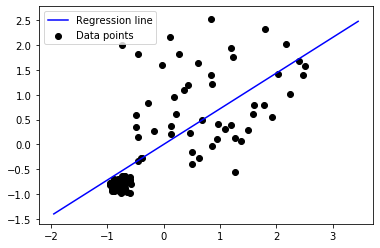

In [ ]:
plotRegressionGraph(np.array(norm_train), regA, ws_a)

In [ ]:
ws_b, fs_b, outputs_b = steepestDescentMethod(f_b, grad_fb, [0,0,0], 0.001)
ws_b, fs_b

Total iteration : 87


(array([[ 0.24248632],
        [ 0.95617381],
        [-0.24248748]]), 43.92721352255019)

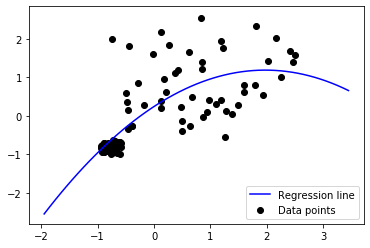

In [ ]:
plotRegressionGraph(np.array(norm_train), regB, ws_b)